In [1]:
# import spark, let the system find it easily with findspark
import findspark
findspark.init('/home/hadoop/spark-2.4.0-bin-hadoop2.7')

In [2]:
# create a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('spark-titanic').getOrCreate()

In [3]:
# read data source. format accepts 'json', 'csv', 'txt'
df = spark.read.format('csv').option('header', 'True').option('inferSchema', 'True').load('s3a://bigd-hadoop/titanic.csv')
df.show(10)

+---------+------+--------+--------------------+-------+-----------+--------------------+-----+----------+-----+------+
|row_names|pclass|survived|                name|    age|   embarked|           home_dest| room|    ticket| boat|   sex|
+---------+------+--------+--------------------+-------+-----------+--------------------+-----+----------+-----+------+
|        1|   1st|       1|Allen, Miss Elisa...|29.0000|Southampton|        St Louis, MO|  B-5|24160 L221|    2|female|
|        2|   1st|       0|Allison, Miss Hel...| 2.0000|Southampton|Montreal, PQ / Ch...|  C26|      null| null|female|
|        3|   1st|       0|Allison, Mr Hudso...|30.0000|Southampton|Montreal, PQ / Ch...|  C26|      null|(135)|  male|
|        4|   1st|       0|Allison, Mrs Huds...|25.0000|Southampton|Montreal, PQ / Ch...|  C26|      null| null|female|
|        5|   1st|       1|Allison, Master H...| 0.9167|Southampton|Montreal, PQ / Ch...|  C22|      null|   11|  male|
|        6|   1st|       1|  Anderson, M

In [4]:
# we can take a quick look at the data with describe()
desc_df = df.describe()
desc_df.select('summary','pclass','survived','name','age','embarked','room').show()

+-------+------+-------------------+--------------------+------------------+-----------+------+
|summary|pclass|           survived|                name|               age|   embarked|  room|
+-------+------+-------------------+--------------------+------------------+-----------+------+
|  count|  1313|               1313|                1313|              1313|        821|    77|
|   mean|  null|  0.341964965727342|                null| 31.19418104265403|       null|2131.0|
| stddev|  null|0.47454867068071604|                null|14.747525275652208|       null|   NaN|
|    min|   1st|                  0|"Brown, Mrs James...|            0.1667|  Cherbourg|  2131|
|    max|   3rd|                  1|del Carlo, Mrs Se...|                NA|Southampton|   F-?|
+-------+------+-------------------+--------------------+------------------+-----------+------+



In [5]:
# how many rows and columns?
print('dataframe rows: ', df.count())
print('columns: ', len(df.columns))

dataframe rows:  1313
columns:  11


In [6]:
# take a look at the schema
df.printSchema()

root
 |-- row_names: integer (nullable = true)
 |-- pclass: string (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- age: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- home_dest: string (nullable = true)
 |-- room: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- sex: string (nullable = true)



Looking at the schema, the first thing we notice is that 'age' and 'class' are strings. We expected those to be numbers, so we need to transform them first.

#### We will be showing the resulting dataframe everytime we make a tranformation of the data

In [7]:
# find out the different classes
df.select('pclass').distinct().show()

+------+
|pclass|
+------+
|   2nd|
|   1st|
|   3rd|
+------+



We use UDF (User Defined Functions) to create class_index (string to number conversion)


An example of UDF using the Lambda Function:

age_udf = udf(lambda age: 'young' if age <= 30 else 'senior', StringType())

df = df.withColumn('age_group', age_udf(df.age)).show()

source: Singh, P. (2019). Machine Learning with PySpark With Natural Language Processing and Recommender Systems. Berkeley: Apress. doi: https://doi.org/10.1007/978-1-4842-4131-8

In [8]:
from pyspark.sql.functions import udf, when, col
from pyspark.sql.types import StringType, DoubleType, IntegerType#, ByteType

class_udf = udf(lambda pclass: 1 if pclass == '1st' else (2 if pclass == '2nd' else 3), IntegerType())
df = df.withColumn('class_index', class_udf(df['pclass']))
df.select('name','pclass','class_index').orderBy('name', ascending=False).show()

+--------------------+------+-----------+
|                name|pclass|class_index|
+--------------------+------+-----------+
|del Carlo, Mrs Se...|   2nd|          2|
|del Carlo, Mr Seb...|   2nd|          2|
|de Villiers, Mada...|   1st|          1|
|de Brito, Mr Jose...|   2nd|          2|
|      Zimmerman, Leo|   3rd|          3|
|       Zievens, Rene|   3rd|          3|
|     Zenn, Mr Philip|   3rd|          3|
|Zakarian, Mr Mapr...|   3rd|          3|
|  Zakarian, Mr Artun|   3rd|          3|
| Zabour, Miss Tamini|   3rd|          3|
| Zabour, Miss Hileni|   3rd|          3|
|Yrois, Miss Henri...|   2nd|          2|
|  Youssef, Mr Gerios|   3rd|          3|
|Young, Miss Marie...|   1st|          1|
| Yasbeck, Mrs Antoni|   3rd|          3|
|  Yasbeck, Mr Antoni|   3rd|          3|
|   Yalsevac, Mr Ivan|   3rd|          3|
|   Wright, Mr George|   1st|          1|
| Wright, Miss Marion|   2nd|          2|
|    Woolner, Mr Hugh|   1st|          1|
+--------------------+------+-----

In [9]:
# next column 'survived'. It looks good with only 0's and 1's
df.select('survived').distinct().show()

+--------+
|survived|
+--------+
|       1|
|       0|
+--------+



In [10]:
# can we extract some info from 'name'?
df.groupBy('name').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|                name|count|
+--------------------+-----+
|     Kelly, Mr James|    2|
| Connolly, Miss Kate|    2|
|Carlsson, Mr Fran...|    2|
|Widener, Mr Georg...|    1|
|Coleridge, Mr Reg...|    1|
|Rosblom, Miss Sal...|    1|
|Porter, Mr Walter...|    1|
|   Hart, Mr Benjamin|    1|
|Brocklebank, Mr W...|    1|
|    Coxon, Mr Daniel|    1|
|    Denkoff, Mr Mito|    1|
|   Herman, Miss Kate|    1|
|      Dibo, Mr Elias|    1|
|    Kelly, Miss Mary|    1|
| Nenkoff, Mr Christo|    1|
|Odahl, Mr Nils Ma...|    1|
| Thomas, Mr John, Jr|    1|
|Long, Mr Milton C...|    1|
|    Foley, Mr Joseph|    1|
|Jonsson, Nils Hil...|    1|
+--------------------+-----+
only showing top 20 rows



Found 3 duplicates, just drop them.

In [11]:
# count rows before and after dropping duplicates
print('dataframe rows: ', df.count())

df = df.dropDuplicates(['name'])

print('dataframe rows after duplicates drop: ', df.count())
# it was good to eliminate some duplicate rows but at the end we will drop this column 

dataframe rows:  1313
dataframe rows after duplicates drop:  1310


It was helpful since we eliminated some duplicates but at the end, the column 'name' will not be considered for the final dataframe

In [12]:
# groupby 'age' just to find out how many NULL values do we have on that column
df.groupBy('age').count().orderBy('count', ascending=False).show(5)

+-------+-----+
|    age|count|
+-------+-----+
|     NA|  679|
|30.0000|   28|
|18.0000|   25|
|36.0000|   23|
|24.0000|   22|
+-------+-----+
only showing top 5 rows



To deal with the NULL values, we will follow the standard practice of creating a new imputed column. Values will depend on whether the column was imputed=1 (meaning the original value was NULL, then replaced) or imputed=0 (value not replaced)

In [13]:
# first, transform 'age' from StringType to DoubleType
df = df.withColumn('age', df['age'].cast(DoubleType()))
df.printSchema()

root
 |-- row_names: integer (nullable = true)
 |-- pclass: string (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- age: double (nullable = true)
 |-- embarked: string (nullable = true)
 |-- home_dest: string (nullable = true)
 |-- room: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- class_index: integer (nullable = true)



In [14]:
# create age_imputed column before filling null values
from pyspark.sql import functions as F
df = df.select(col('*'), F.when(df['age'] > 0, 0).otherwise(1).alias('age_imputed'))
df.select(['name','age','age_imputed']).show()

+--------------------+----+-----------+
|                name| age|age_imputed|
+--------------------+----+-----------+
|Harbeck, Mr Willi...|44.0|          0|
|       Lang, Mr Fang|null|          1|
|Levy, Mr Rene Jac...|null|          1|
|Padro y Manent, M...|null|          1|
|Salkjelsvik, Miss...|null|          1|
|Allison, Miss Hel...| 2.0|          0|
|Candee, Mrs Edwar...|53.0|          0|
|Carter, Mrs Willi...|36.0|          0|
|Hakkarainen, Mr P...|null|          1|
|Landegren, Miss A...|null|          1|
|  Thomas, Mr Charles|null|          1|
|Colley, Mr Edward...|null|          1|
|Harknett, Miss Alice|null|          1|
|Rosblom, Miss Sal...|null|          1|
|Brocklebank, Mr W...|35.0|          0|
|    Coxon, Mr Daniel|59.0|          0|
|   Hart, Mr Benjamin|43.0|          0|
|Widener, Mr Georg...|50.0|          0|
|Doyle, Miss Eliza...|24.0|          0|
|Futrelle, Mr Jacques|37.0|          0|
+--------------------+----+-----------+
only showing top 20 rows



In [15]:
# get the mean of 'age' to fill in the null values
from pyspark.sql.functions import mean, format_number

mean_age = df.select(format_number(mean(df['age']), 2)).collect()
#mean_age = df.select(mean(df['age'])).collect()
mean_age

[Row(format_number(avg(age), 2)='31.21')]

In [16]:
# mean_age as a float
mean_age = float(mean_age[0][0])
mean_age

31.21

we could fill the NULL values on 'age' with mean_age
* df = df.na.fill(mean_age, 'age').show()

In [17]:
# or better use Spark's imputer feature
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=['age'], outputCols=['new_age'])
model = imputer.fit(df)

df = model.transform(df)
df.select(['name','age','age_imputed','new_age']).show()

+--------------------+----+-----------+------------------+
|                name| age|age_imputed|           new_age|
+--------------------+----+-----------+------------------+
|Harbeck, Mr Willi...|44.0|          0|              44.0|
|       Lang, Mr Fang|null|          1|31.205890015847856|
|Levy, Mr Rene Jac...|null|          1|31.205890015847856|
|Padro y Manent, M...|null|          1|31.205890015847856|
|Salkjelsvik, Miss...|null|          1|31.205890015847856|
|Allison, Miss Hel...| 2.0|          0|               2.0|
|Candee, Mrs Edwar...|53.0|          0|              53.0|
|Carter, Mrs Willi...|36.0|          0|              36.0|
|Hakkarainen, Mr P...|null|          1|31.205890015847856|
|Landegren, Miss A...|null|          1|31.205890015847856|
|  Thomas, Mr Charles|null|          1|31.205890015847856|
|Colley, Mr Edward...|null|          1|31.205890015847856|
|Harknett, Miss Alice|null|          1|31.205890015847856|
|Rosblom, Miss Sal...|null|          1|31.20589001584785

In [18]:
# take a look at 'embarked': 3 categories + null
df.groupBy('embarked').count().orderBy('count', ascending=False).show()

+-----------+-----+
|   embarked|count|
+-----------+-----+
|Southampton|  572|
|       null|  491|
|  Cherbourg|  203|
| Queenstown|   44|
+-----------+-----+



In [19]:
# import libraries for indexer creation
from pyspark.ml.feature import StringIndexer

# we can either impute the NULL values with whatever arbitrary value we want or let spark do it.
# here we use handleInvalid="keep" to account for those NULL values. It will automatically create a 4th category with all the Nulls
emb_indexer = StringIndexer(inputCol='embarked', outputCol='embarked_index', handleInvalid="keep")
df = emb_indexer.fit(df).transform(df)
df.select(['name','embarked','embarked_index']).show()

+--------------------+-----------+--------------+
|                name|   embarked|embarked_index|
+--------------------+-----------+--------------+
|Harbeck, Mr Willi...|Southampton|           0.0|
|       Lang, Mr Fang|       null|           3.0|
|Levy, Mr Rene Jac...|  Cherbourg|           1.0|
|Padro y Manent, M...|  Cherbourg|           1.0|
|Salkjelsvik, Miss...|       null|           3.0|
|Allison, Miss Hel...|Southampton|           0.0|
|Candee, Mrs Edwar...|  Cherbourg|           1.0|
|Carter, Mrs Willi...|Southampton|           0.0|
|Hakkarainen, Mr P...|       null|           3.0|
|Landegren, Miss A...|       null|           3.0|
|  Thomas, Mr Charles|       null|           3.0|
|Colley, Mr Edward...|Southampton|           0.0|
|Harknett, Miss Alice|       null|           3.0|
|Rosblom, Miss Sal...|       null|           3.0|
|Brocklebank, Mr W...|Southampton|           0.0|
|    Coxon, Mr Daniel|Southampton|           0.0|
|   Hart, Mr Benjamin|Southampton|           0.0|


In [20]:
# although less nulls than other columns, the problem with home_dest is lack of uniformity.
# this column will receive the same treatment as the 'name' column. we'll just drop it
df.groupBy('home_dest').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|           home_dest|count|
+--------------------+-----+
|                null|  558|
|        New York, NY|   64|
|              London|   14|
|        Montreal, PQ|   10|
|       Paris, France|    9|
|Cornwall / Akron, OH|    9|
|Wiltshire, Englan...|    8|
|        Winnipeg, MB|    8|
|    Philadelphia, PA|    8|
| Sweden Winnipeg, MN|    7|
|        Brooklyn, NY|    7|
|             Belfast|    7|
|Rotherfield, Suss...|    5|
|          Ottawa, ON|    5|
|Sweden Worcester, MA|    5|
|Bulgaria Chicago, IL|    5|
|Somerset / Bernar...|    5|
|Haverford, PA / C...|    5|
|      Youngstown, OH|    5|
|  Syria New York, NY|    4|
+--------------------+-----+
only showing top 20 rows



In [21]:
# in 'room' we see a lot of null values, but we can still get some categories if we take only the first letter
df.groupBy('room').count().orderBy('count', ascending=False).show()

+--------+-----+
|    room|count|
+--------+-----+
|    null| 1233|
|    F-33|    4|
|     C26|    3|
|   C-101|    3|
|   E-101|    3|
|B-51/3/5|    2|
|     B-5|    2|
|    C-85|    2|
|    C-93|    2|
|    B-18|    2|
| B-58/60|    2|
|     D-?|    2|
|     C22|    2|
|   C-125|    2|
|    D-35|    2|
|   C-126|    2|
|    C-83|    2|
|    C-87|    2|
|    B-49|    2|
|     C-7|    2|
+--------+-----+
only showing top 20 rows



In [22]:
# create room_imputed column before filling nulls
df = df.select(col('*'), F.when(df['room'].isNull(), 1).otherwise(0).alias('room_imputed'))

# create room_category taking the first letter from room_number
from pyspark.sql.functions import col, substring
df = df.select(col('*'), substring(col('room'), 0, 1).alias('room_categ'))

# create index for room
# we use again handleInvalid="keep" to include null values in the index
room_indexer = StringIndexer(inputCol='room_categ', outputCol='room_index', handleInvalid="keep")
df = room_indexer.fit(df).transform(df)
df.select('name','room','room_imputed','room_categ','room_index').orderBy('room', ascending=False).show()

+--------------------+------+------------+----------+----------+
|                name|  room|room_imputed|room_categ|room_index|
+--------------------+------+------------+----------+----------+
|    Swane, Mr George|   F-?|           0|         F|       4.0|
| Brown, Miss Mildred|  F-33|           0|         F|       4.0|
|  Lemore, Mrs Amelia|  F-33|           0|         F|       4.0|
|Nye, Mrs Elizabet...|  F-33|           0|         F|       4.0|
|Cook, Mrs Selena ...|  F-33|           0|         F|       4.0|
|      Mack, Mrs Mary|   E77|           0|         E|       3.0|
|     Buss, Miss Kate|   E-?|           0|         E|       3.0|
|  Anderson, Mr Harry|  E-12|           0|         E|       3.0|
|Troutt, Miss Edwi...| E-101|           0|         E|       3.0|
|  Webber, Miss Susan| E-101|           0|         E|       3.0|
| Keane, Miss Nora A.| E-101|           0|         E|       3.0|
|Longley, Miss Gre...|   D-?|           0|         D|       2.0|
|Hogeboom, Mrs Joh...|   

In [23]:
# 'ticket' is mostly NULL's. we'll drop it too
df.groupBy('ticket').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|              ticket|count|
+--------------------+-----+
|                null| 1241|
|    17608 L262 7s 6d|    5|
|          230136 L39|    4|
|          24160 L221|    3|
|          230080 L26|    3|
|       28220 L32 10s|    3|
|           13502 L77|    3|
|    17582 L153 9s 3d|    3|
|   17754 L224 10s 6d|    3|
|        13529 L26 5s|    3|
|     36973 L83 9s 6d|    2|
|   111361 L57 19s 7d|    2|
|              392091|    2|
|       17755 L512 6s|    2|
|   17483 L221 15s 7d|    2|
|               17483|    2|
|               17754|    2|
|112058 Complimentary|    1|
|    17591 L50 9s 11d|    1|
|              L15 1s|    1|
+--------------------+-----+
only showing top 20 rows



In [24]:
# extracting some data from 'boat' looks really challenging. we can try just to index it
df.groupBy('boat').count().orderBy('count', ascending=False).show()

+----+-----+
|boat|count|
+----+-----+
|null|  963|
|   4|   27|
|   5|   27|
|   7|   22|
|   3|   19|
|   8|   18|
|  11|   17|
|   6|   17|
|  13|   16|
|   9|   15|
|  14|   15|
|  12|   13|
|   2|   11|
|   D|   10|
|  10|    8|
|  15|    6|
|   C|    6|
|   B|    6|
|   A|    5|
|   1|    4|
+----+-----+
only showing top 20 rows



In [25]:
# create index for boat
boat_indexer = StringIndexer(inputCol='boat', outputCol='boat_index', handleInvalid="keep")
df = boat_indexer.fit(df).transform(df)
df.select('name','boat','boat_index').orderBy('name').show()

+--------------------+-----+----------+
|                name| boat|boat_index|
+--------------------+-----+----------+
|"Brown, Mrs James...|    6|       6.0|
|  Abbing, Mr Anthony| null|      99.0|
|Abbott, Master Eu...| null|      99.0|
|Abbott, Mr Rossmo...|(190)|      62.0|
|Abbott, Mrs Stant...|    A|      17.0|
|Abelseth, Miss An...|   16|      21.0|
|  Abelseth, Mr Olaus|    A|      17.0|
|  Abelson, Mr Samuel| null|      99.0|
|Abelson, Mrs Samu...|   12|      10.0|
|Abraham, Mrs Jose...| null|      99.0|
|Abrahamsson, Mr A...|   15|      14.0|
|Adahl, Mr Mauritz...| (72)|      52.0|
|      Adams, Mr John|(103)|      85.0|
|Ahlin, Mrs Johann...| null|      99.0|
|       Ahmed, Mr Ali| null|      99.0|
| Aijo-Nirva, Mr Isak| null|      99.0|
|  Aks, Master Philip|   11|       5.0|
|Aks, Mrs Sam (Lea...|   13|       7.0|
|Aldworth, Mr Char...| null|      99.0|
|Alexander, Mr Wil...| null|      99.0|
+--------------------+-----+----------+
only showing top 20 rows



In [26]:
# final column to transform: 'sex'
df.groupBy('sex').count().orderBy('count', ascending=False).show()

+------+-----+
|   sex|count|
+------+-----+
|  male|  848|
|female|  462|
+------+-----+



In [27]:
# create index for sex
sex_indexer = StringIndexer(inputCol='sex', outputCol='sex_index')
df = sex_indexer.fit(df).transform(df)
df.select('name','sex','sex_index').show()

+--------------------+------+---------+
|                name|   sex|sex_index|
+--------------------+------+---------+
|Harbeck, Mr Willi...|  male|      0.0|
|       Lang, Mr Fang|  male|      0.0|
|Levy, Mr Rene Jac...|  male|      0.0|
|Padro y Manent, M...|  male|      0.0|
|Salkjelsvik, Miss...|female|      1.0|
|Allison, Miss Hel...|female|      1.0|
|Candee, Mrs Edwar...|female|      1.0|
|Carter, Mrs Willi...|female|      1.0|
|Hakkarainen, Mr P...|  male|      0.0|
|Landegren, Miss A...|female|      1.0|
|  Thomas, Mr Charles|  male|      0.0|
|Colley, Mr Edward...|  male|      0.0|
|Harknett, Miss Alice|female|      1.0|
|Rosblom, Miss Sal...|female|      1.0|
|Brocklebank, Mr W...|  male|      0.0|
|    Coxon, Mr Daniel|  male|      0.0|
|   Hart, Mr Benjamin|  male|      0.0|
|Widener, Mr Georg...|  male|      0.0|
|Doyle, Miss Eliza...|female|      1.0|
|Futrelle, Mr Jacques|  male|      0.0|
+--------------------+------+---------+
only showing top 20 rows



## IMPORTANT!   
### For all index columns created, now transform them to vectors

In [28]:
# recall all the columns on the dataframe
df.columns

['row_names',
 'pclass',
 'survived',
 'name',
 'age',
 'embarked',
 'home_dest',
 'room',
 'ticket',
 'boat',
 'sex',
 'class_index',
 'age_imputed',
 'new_age',
 'embarked_index',
 'room_imputed',
 'room_categ',
 'room_index',
 'boat_index',
 'sex_index']

In [29]:
# transform all indexes to one_hot_encode vectors
from pyspark.ml.feature import OneHotEncoderEstimator

class_encoder = OneHotEncoderEstimator(inputCols=['class_index'], outputCols=['class_vect'])
df = class_encoder.fit(df).transform(df)

In [30]:
emb_encoder = OneHotEncoderEstimator(inputCols=['embarked_index'], outputCols=['embarked_vect'])
df = emb_encoder.fit(df).transform(df)

In [31]:
room_encoder = OneHotEncoderEstimator(inputCols=['room_index'], outputCols=['room_vect'])
df = room_encoder.fit(df).transform(df)

In [32]:
boat_encoder = OneHotEncoderEstimator(inputCols=['boat_index'], outputCols=['boat_vect'])
df = boat_encoder.fit(df).transform(df)

In [33]:
sex_encoder = OneHotEncoderEstimator(inputCols=['sex_index'], outputCols=['sex_vect'])
df = sex_encoder.fit(df).transform(df)

In [34]:
# final step before creating any ML model: Single vector with all transformed columns and columns created when imputing values
df.columns

['row_names',
 'pclass',
 'survived',
 'name',
 'age',
 'embarked',
 'home_dest',
 'room',
 'ticket',
 'boat',
 'sex',
 'class_index',
 'age_imputed',
 'new_age',
 'embarked_index',
 'room_imputed',
 'room_categ',
 'room_index',
 'boat_index',
 'sex_index',
 'class_vect',
 'embarked_vect',
 'room_vect',
 'boat_vect',
 'sex_vect']

In [35]:
# first select only the labels and features we have created to this point
df = df.select(['survived', 'class_index', 'age_imputed', 'new_age', 'embarked_index'
               ,'room_imputed', 'room_categ', 'room_index', 'boat_index', 'sex_index'
               ,'class_vect', 'embarked_vect', 'room_vect', 'boat_vect', 'sex_vect'])

# create a single vector only with valid features (no indexes or labels)
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['class_vect', 'age_imputed', 'new_age', 'embarked_vect', 'room_imputed', 'room_vect', 'boat_vect', 'sex_vect'],
    outputCol='features')

final_df = assembler.transform(df)
final_df = final_df.select('features', 'survived')

print("Assembled features:") 
print("['class_vect', 'age_imputed', 'new_age', 'embarked_vect', 'room_imputed', 'room_vect', 'boat_vect', 'sex_vect']")
final_df.show()

Assembled features:
['class_vect', 'age_imputed', 'new_age', 'embarked_vect', 'room_imputed', 'room_vect', 'boat_vect', 'sex_vect']
+--------------------+--------+
|            features|survived|
+--------------------+--------+
|(116,[2,4,5,8,66,...|       0|
|(116,[3,4,8,115],...|       1|
|(116,[2,3,4,6,8,1...|       0|
|(116,[2,3,4,6,8,1...|       1|
|(116,[3,4,8],[1.0...|       1|
|(116,[1,4,5,9],[1...|       0|
|(116,[1,4,6,8,22]...|       1|
|(116,[1,4,5,8,16]...|       1|
|(116,[3,4,8,115],...|       0|
|(116,[3,4,8],[1.0...|       1|
|(116,[3,4,8,115],...|       0|
|(116,[1,3,4,5,8,1...|       0|
|(116,[3,4,8],[1.0...|       0|
|(116,[3,4,8],[1.0...|       0|
|(116,[4,5,8,115],...|       0|
|(116,[4,5,8,115],...|       0|
|(116,[2,4,5,8,115...|       0|
|(116,[1,4,6,8,115...|       0|
|(116,[4,7,8],[24....|       0|
|(116,[1,4,5,8,115...|       0|
+--------------------+--------+
only showing top 20 rows



## Finally!!!
Now we can create our regression model

In [36]:
# split the data with an 70/30 ratio
from pyspark.ml.classification import LogisticRegression
train_data, test_data = final_df.randomSplit([0.7, 0.3], seed=7)

In [37]:
# create model
lr_titanic = LogisticRegression(featuresCol='features', labelCol='survived')

In [38]:
# train the model
lr_model = lr_titanic.fit(train_data)

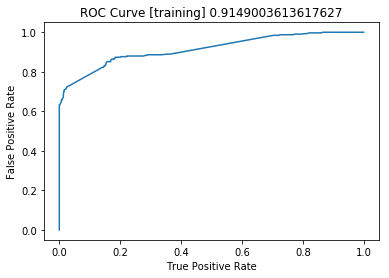

In [39]:
# we can evaluate the performance of our model with a roc curve
%matplotlib inline
import matplotlib.pyplot as plt

lr_summary = lr_model.summary
roc = lr_summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve [training] ' + str(lr_summary.areaUnderROC));

In [40]:
# get predictions with test_data
lr_results = lr_model.transform(test_data)

# the schema of results will give us the resulting vectors available for evaluation
lr_results.printSchema()

root
 |-- features: vector (nullable = true)
 |-- survived: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [41]:
# take a look a the actual predictions
lr_results.select('survived', 'prediction').show()

+--------+----------+
|survived|prediction|
+--------+----------+
|       0|       0.0|
|       1|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       0.0|
|       0|       0.0|
|       1|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       1.0|
|       0|       0.0|
|       1|       1.0|
|       0|       0.0|
|       1|       1.0|
+--------+----------+
only showing top 20 rows



In [42]:
# last, we can evaluate our model with test_data
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='survived')

lr_score = lr_eval.evaluate(lr_results)
print('Area under the curve [testing]:', lr_score)

Area under the curve [testing]: 0.8635787533125936


### That's a pretty good model.

Now, let's create other different models and compare performance

In [43]:
# we want to evaluate performance of Decision Trees, Random Forest and Gradient Boosting
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

In [44]:
# create the 3 different models
dtc = DecisionTreeClassifier(labelCol='survived', featuresCol='features')
rfc = RandomForestClassifier(labelCol='survived', featuresCol='features')
gbc = GBTClassifier(labelCol='survived', featuresCol='features')

In [45]:
# train the models
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
gbc_model = gbc.fit(train_data)

In [46]:
# get the predictions with test_data
dtc_preds = dtc_model.transform(test_data)
rfc_preds = rfc_model.transform(test_data)
gbc_preds = gbc_model.transform(test_data)

In [47]:
# we can see the resulting vectors available for evaluation (actually those are same from linear_regression)
dtc_preds.printSchema()

root
 |-- features: vector (nullable = true)
 |-- survived: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [48]:
# to evaluate our model we use again BinaryClassificationEvaluator
binary_eval = BinaryClassificationEvaluator(labelCol='survived')

print('Logistic regression:', lr_score)
print('Decision Tree Classifier:', binary_eval.evaluate(dtc_preds))
print('Random Forest Classifier:', binary_eval.evaluate(rfc_preds))
print('Gradient Boosting Classifier:', binary_eval.evaluate(gbc_preds))

Logistic regression: 0.8635787533125936
Decision Tree Classifier: 0.44316741560087564
Random Forest Classifier: 0.9011262818297039
Gradient Boosting Classifier: 0.9347707109113953


#### surprisingly, random forest performs just above than our logistic regression model

### Gradient Boosting Classifier turns out to be the best one among the 4 chosen models

### (Logistic Regression, Decision Trees, Random Forest, Gradient Boosting)

As a final note, we should remember that we used the default parameters when creating the classification models.
There are dozens of parameters we can start tuning in order to get a better score on each one of the models created